## Automatic Modulation Classificarion (AMC) utilizando técnicas de Machine Learning (Random Forests, SVM e Redes Neurais MLP)

Este notebook é para o projeto da disciplina Comunicação Digital da Universidade Federal do ABC.
Iremos utilizar o dataset Communication-Digital-Signals criado pelo Professor Dr. Baochang Zhang e utilizado no paper Automatic Modulation Classification Based on Deep Learning for Unmanned Aerial Vehicles (https://pdfs.semanticscholar.org/7376/187ab51f95cf07f913bd98fab9a6fa7823c3.pdf)

### Introdução

Neste notebook iremos classificar qual tipo de modulação pertence um certo sinal. Com grandes aplicações em área militares, de compliance e identificação de usuários que fazem uso indevido do sinal de comunicação, é de extrema importância o desenvolvimento de algoritmos capazes de identificar de forma confiável qual tipo de modulação trata-se um sinal, a fim de determinar seu conteúdo do método mais apropriado.

Os dados foram gerados pelo Dr. Baochang Zhang e podem ser encontrados em seu repositório no github (https://github.com/bczhangbczhang/Communication-Signal-Dataset). O dataset foi criado a partir de um simulador de dados geográficos do Visual Studio e simuladores de canais e modulações no Matlab. Basicamente, temos um sinal recebido da seguinte forma:
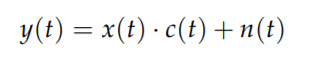

Onde y(t) é o sinal recebido, x(t) o sinal modulado, n(t) ruído AWGN e c(t) representa as especificações do canal (fading, etc). Assim, temos ao total 22000 dados com 963 amostras e o label de modulação que ele representa, sendo de 0-10 representando 2ASK, 2FSK, 2PSK, 4ASK, 4FSK, 4PSK, 8ASK, 8FSK, 8PSK, 16QAM e 64QAM, respectivamente. Para a mesma situação, foram gerados também dados variando-se a SNR, com valores de 0, 4, 8, 12, 16 e 20 dB.

### Pré-processamento

Vamos começar por importar os dados, tratá-los da forma adequada e separarmos eles em dados de treino e teste utilizando as bibliotecas do scipy, numpy, pandas e scikit-learn.

In [93]:
import pandas as pd
import scipy.io

mat = scipy.io.loadmat('data-8.mat')  

label_map = ['2ASK', '2FSK', '2PSK', '4ASK', '4FSK', '4PSK', '8ASK', '8FSK', '8PSK', '16QAM', '64QAM']
label_map = dict(zip(range(11), label_map))
label_map

{0: '2ASK',
 1: '2FSK',
 2: '2PSK',
 3: '4ASK',
 4: '4FSK',
 5: '4PSK',
 6: '8ASK',
 7: '8FSK',
 8: '8PSK',
 9: '16QAM',
 10: '64QAM'}

In [94]:
# As 963 amostras temporais vem na forma colunar, gostaríamos de colocá-los por linhas, 
# este passo então irá colocar a cada linha uma amostra do sinal temporal, bem como sua categoria

all_dfs = []
for i in range(22000):
    df = pd.DataFrame(mat['Qt'][0][i][0], columns = ['realizations', 'labels']).T
    df['label'] = df.loc['labels'][0]
    df = df.drop(['labels'], axis=0)
    all_dfs.append(df)

In [95]:
data = pd.concat(all_dfs)
data = data.reset_index(drop=True)

In [96]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,951,952,953,954,955,956,957,958,959,label
0,0.820464,0.726486,0.510712,0.343558,0.290709,0.366247,0.517827,0.752709,0.779955,0.719940,...,0.748857,0.754128,0.713617,0.521617,0.371254,0.236886,0.299190,0.522693,0.726867,0.0
1,0.807467,0.619497,0.618561,0.675334,0.448838,0.431104,0.317677,0.481104,0.249112,0.320491,...,0.605159,0.714560,0.685380,0.609706,0.322134,0.220908,0.240624,0.565649,0.657717,1.0
2,0.246404,0.371717,0.555008,0.618323,0.580389,0.664642,0.563636,0.343797,0.229394,0.270854,...,0.776534,0.761257,0.690087,0.500493,0.285487,0.264822,0.281686,0.462832,0.615862,2.0
3,0.684792,0.549584,0.510974,0.393616,0.387274,0.522693,0.638008,0.568677,0.548238,0.578292,...,0.685379,0.559858,0.587314,0.460903,0.391586,0.375129,0.457790,0.626912,0.496669,3.0
4,0.624828,0.826303,0.634223,0.650169,0.615344,0.425413,0.502878,0.397682,0.295608,0.402082,...,0.710602,0.548100,0.739188,0.516816,0.327807,0.360805,0.333105,0.511796,0.670320,4.0


Vamos verificar e plotar alguns sinais no domínio do tempo para visualização.

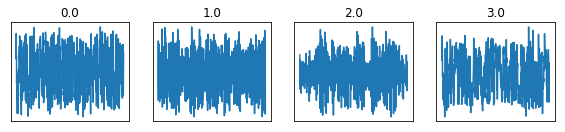

In [97]:
import random
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

amostras = random.sample(list(range(11)), 4)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.plot(data[[col for col in data.columns if col!='label']].loc[amostras[idx],:])
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(data.label.values[idx])


Verificamos portanto que a partir de uma análise crua do sinal, não conseguimos diferenciá-los de forma adequada e identificarmos qual tipo de modulação estamos trabalhando.

In [98]:
X = data[[col for col in data.columns if col!='label']]
y = data.label

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
X_train.shape, X_test.shape

((11000, 960), (11000, 960))

In [99]:
import pywt
import pywt.data

def wavelet_transform(X):
    cAs = np.zeros((X.shape[0], int(X.shape[1] / 2)))
    cDs = np.zeros((X.shape[0], int(X.shape[1] / 2)))
    j = 0
    for i in list(X.index):
        cA_train, cD_train = pywt.dwt([X.loc[i,:]], 'haar')
        cAs[j] = cA_train
        cDs[j] = cD_train
        j += 1
        
    return cAs, cDs

cA_train, cD_train = wavelet_transform(X_train)
cA_test, cD_test = wavelet_transform(X_test)
cA_train.shape, cA_test.shape

((11000, 480), (11000, 480))

Separamos nossos dados então em 50% para treino e 50% para teste.

### Modelos: Máquinas de Vetor de Suporte

Vamos começar pela SVM. SVM tem boa performance para dados com alta esparsidade, o que seria nosso caso com 963 amostras, assim, vamos treinar um modelo variando seu custo C, associado à quantidade de erros que o modelo pode ter a partir de uma fronteira de decisão.

In [100]:
#from sklearn.svm import SVC
#from pykernels.regular import Wavelet
#svm = SVC(kernel=Wavelet(a = 2))
#
#svm.fit(X_train, y_train)
#svm.score(X_test, y_test)
pd.Series(y_train).value_counts(normalize=True)
pd.Series(y_test).value_counts(normalize=True)

0.0     0.092000
6.0     0.091909
9.0     0.091818
4.0     0.091818
8.0     0.091727
5.0     0.091273
2.0     0.091091
10.0    0.090455
3.0     0.090182
7.0     0.090000
1.0     0.087727
Name: label, dtype: float64

In [101]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(cA_train, y_train)
print('Para dados com CA: {}'.format(svm.score(cA_test, y_test)))
      
svm = LinearSVC()
svm.fit(X_train, y_train)
print('Para dados sem CA: {}'.format(svm.score(X_test, y_test)))

Para dados com CA: 0.6679090909090909
Para dados sem CA: 0.6185454545454545


In [102]:
scores, scores_cA = {}, {}
scores['0'], scores_cA['0'] = 0.59, 0.66
scores['4'], scores_cA['4'] = 0.56, 0.62
scores['8'], scores_cA['8'] = 0.6066, 0.68
scores['12'],scores_cA['12'] = 0.53, 0.56
scores['16'],scores_cA['16'] = 0.561, 0.579
scores['20'],scores_cA['20'] = 0.50, 0.537

Normalized confusion matrix


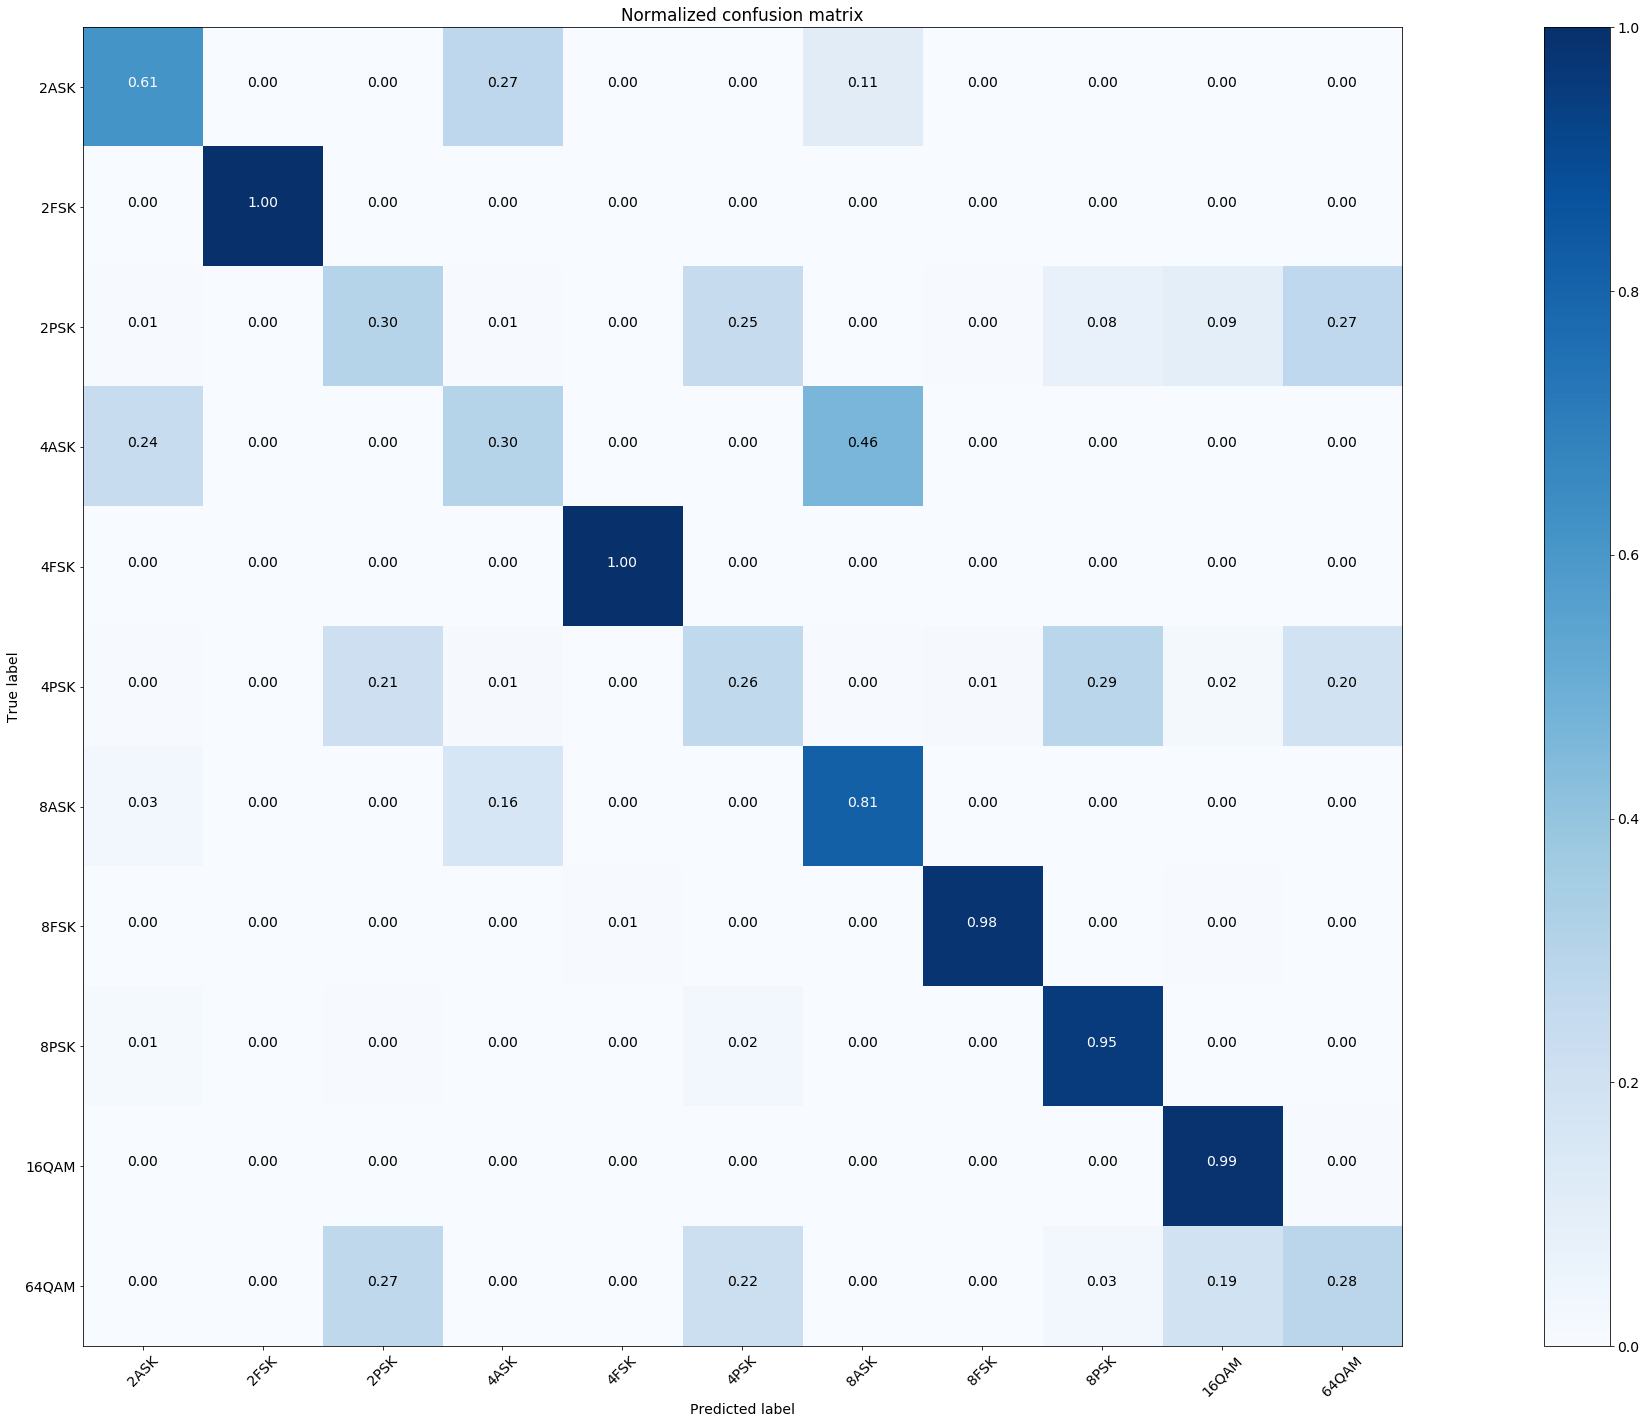

In [104]:
import itertools
from sklearn.metrics import confusion_matrix

svm.fit(cA_train, y_train)
class_names = label_map.values()# svm.classes_
y_pred = svm.predict(cA_test)
plt.rcParams.update({'font.size': 14})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(40,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Cross-validation

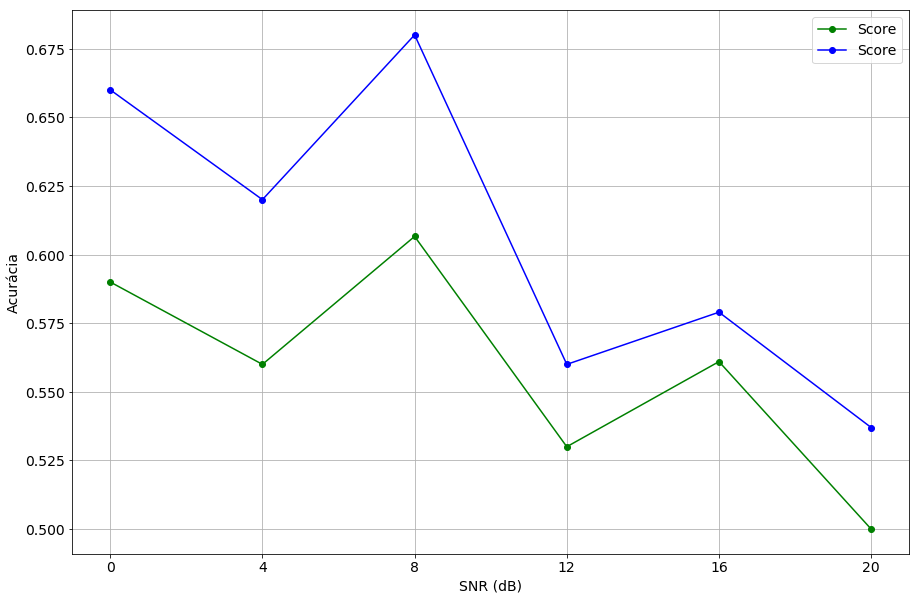

In [91]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.plot(scores.keys(), scores.values(), 'g-o', label = 'Score')
ax.plot(scores_cA.keys(), scores_cA.values(), 'b-o', label = 'Score', )
ax.legend()
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Acurácia')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)